In [168]:
import pandas as pd
import json
import os
import sys
import glob
import graph_tool.all as gt
from datetime import datetime, date, time
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy as np
import math

statistics_dir = '/home/maniaa/ashes/code/statistics/'
stat_csv = [(statistics_dir + f) for f in listdir(statistics_dir) if (f.endswith(".csv") and isfile(join(statistics_dir, f)))]
stat_csv.sort()
stat_csv = stat_csv[1:]

In [169]:
for index, f in enumerate(stat_csv):
    # 6Am of each day
    print(f)
    month, day, year = f.split('/')[-1].split('.csv')[0].split('-')
    trace_starttime = datetime.combine(date(int(year), int(month), int(day)), time(7, 0))
    
    df = pd.read_csv(f)
    df = df[df['submitTime']/1000 > datetime.timestamp(trace_starttime)]
    
    df['submit_ts'] = df['submitTime']//1000 - datetime.timestamp(trace_starttime);
    df.sort_values('submit_ts', inplace=True)
    df.reset_index(inplace=True)
    
    break

/home/maniaa/ashes/code/statistics/08-02-2018.csv


In [170]:
print(df.columns)

Index(['index', 'state', 'submitTime', 'startTime', 'finishTime', 'queueTime',
       'runTime', 'NumMaps', 'avgMapTime', 'avgReduceTime', 'avgShuffleTime',
       'avgMergeTime', 'NumReduce', 'HDFS_INPUT_SIZE', 'HDFS_OUTPUT_SIZE',
       'MAP_CPU_USAGE_MSEC', 'REDUCE_CPU_USAGE_MSEC', 'MAP_MEM_USAGE_B',
       'REDUCE_MEM_USAGE_B', 'HIVE_RECORDS_IN', 'HIVE_RECORDS_OUT',
       'HIVE_RECORDS_INTERMEDIATE', 'SLOTS_MILLIS_MAPS',
       'SLOTS_MILLIS_REDUCES', 'TOTAL_LAUNCHED_MAPS', 'TOTAL_LAUNCHED_REDUCES',
       'DATA_LOCAL_MAPS', 'RACK_LOCAL_MAPS', 'MILLIS_MAPS', 'MILLIS_REDUCES',
       'VCORES_MILLIS_MAPS', 'VCORES_MILLIS_REDUCES', 'MB_MILLIS_MAPS',
       'MB_MILLIS_REDUCES', 'PHMAP_MEM_USAGE_B', 'PHREDUCE_MEM_USAGE_B',
       'PHPHYSICAL_MEMORY_B', 'jobid', 'job.maps', 'query', 'outputdir',
       'scratchdir', 'sessionid', 'query.id', 'local.scratchdir', 'tmpouput',
       'user.name', 'job', 'n_inputs', 'inputdir', 'workflow.node',
       'workflow.id', 'workflow.dag', 'table.nam

In [177]:
metadata = {}

def chop(string):
    return string.split('hdfs://datalake-nnha/', 1)[1].rsplit('-', 1)[0]

def p(data):
    global metadata
    o_obj = chop(data['tmpouput'])
    iobjs = [chop(f) for f in data['inputdir'].split(',')]
    for i_obj in iobjs:
        if i_obj == o_obj:
            o_obj = o_obj.split('.hive')[0]+data['table.name'].rsplit('.')[1]
        
        if i_obj not in metadata:
            metadata[i_obj] = {'id': len(metadata), 'size': data['HDFS_INPUT_SIZE']//data['n_inputs'], 
                               'reuse': 0, 'name': i_obj, 'approximate': 1}
        metadata[i_obj]['reuse'] += 1;
        f.write(str(int(data['submit_ts'])) + ','+ str(metadata[i_obj]['id']) + ','+ str(metadata[i_obj]['size']) + ',r\n')
        
    if o_obj not in metadata:
        metadata[o_obj] = {'id': len(metadata), 'size': data['HDFS_OUTPUT_SIZE'], 'reuse': 0, 
                           'name': o_obj, 'approximate': 0}
    metadata[o_obj]['reuse'] += 1;
    metadata[o_obj]['size'] = data['HDFS_OUTPUT_SIZE'];
    data['outputdir'] = o_obj
    f.write(str(int(data['submit_ts'])) + ','+ str(metadata[o_obj]['id']) + ',' + str(metadata[o_obj]['size']) + ',w\n')
    
#d = df[df['user.name'] == 'kavithad'].sort_values('submitTime').apply(p, axis=1)

f = open("/home/maniaa/ashes/code/replay_trace.tr", "w")
d = df.sort_values('submitTime').apply(p, axis=1)
f.close()

In [204]:
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 40)
metadata_df = pd.DataFrame(data=metadata.values())
metadata_df[metadata_df['name'].str.contains('hive_external_tables/EMS/')]

,id,size,reuse,name,approximate
4402,4402,116136815,40300,hive_external_tables/EMS/2018-05,1
4403,4403,116136815,38600,hive_external_tables/EMS/2018-06,1
4404,4404,116136815,71536,hive_external_tables/EMS/2018-07,1
17349,17349,142218730,4198,hive_external_tables/EMS/2018-04,1
37881,37881,130705113,300,hive_external_tables/EMS/2018-08,1
38507,38507,145321612,3100,hive_external_tables/EMS/2018-03,1


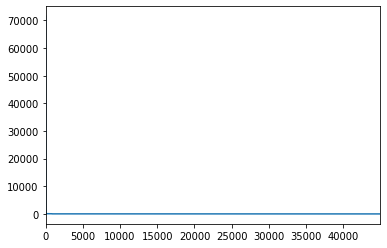

In [205]:
metadata_df = metadata_df.sort_values('reuse', ascending=False).reset_index(drop=True)


In [207]:
metadata_df = metadata_df.sort_values('reuse', ascending=False).reset_index()
metadata_df

,index,id,size,reuse,name,approximate
0,0,4404,116136815,71536,hive_external_tables/EMS/2018-07,1
1,1,4402,116136815,40300,hive_external_tables/EMS/2018-05,1
2,2,5961,7508260764,40027,hive_external_tables/CM/2018-07,1
3,3,4403,116136815,38600,hive_external_tables/EMS/2018-06,1
4,4,26777,0,16500,hive_external_tables/CM/2017-08,1
...,...,...,...,...,...,...
44960,22597,42322,7,1,tmp/hive/saia/4b48f166-e429-456d-a677-a39e20144d40/hive_2018-08-02_21-02-26_335_3072865699720086...,0
44961,22596,42323,7210,1,tmp/hive/gkasha/ef36d240-328d-484b-a15b-cf39e41d334c/hive_2018-08-02_21-00-52_819_90966794615769...,1
44962,22595,42324,52,1,hive_external_tables/Users_db/guestdb/ubs_shelf_asups_sd/.hive-staging_hive_2018-08-02_21-00-52_...,0
44963,22594,42325,11753,1,tmp/hive/netappiq/11ce9432-5e19-45ea-8ab0-0fb0f7fd97f7/hive_2018-08-02_21-02-34_494_129808085763...,1


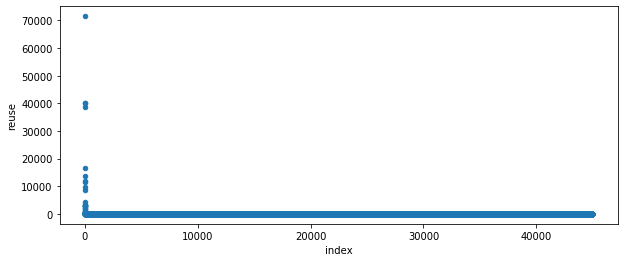

In [210]:
fig, ax = plt.subplots(figsize=(10,4))
metadata_df.plot(kind='scatter', x='index', y='reuse', ax=ax)